In [1]:
import numpy as np
import cv2
import torch
import laspy
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys
sys.path.append(".")
from files import *

In [66]:
camera_intrinsics, distortion_coefficients = read_camera_intrinsics_agisoft("../../data/box_canyon_export/camera_intrinsics.xml")
cameras = read_camera_extrinsics_agisoft("../../data/box_canyon_export/camera_extrinsics.xml")

In [67]:
extrinsic_matrix = cameras['G:/zhiang/webodm_box_canyon/mission_2/DJI_0247.JPG']

print(extrinsic_matrix)

[[-5.97573017e-01 -7.91932875e-01  1.25494270e-01  4.32761423e+05]
 [-8.01197553e-01  5.83615771e-01 -1.32193469e-01  3.74973898e+06]
 [ 3.14479185e-02 -1.79540952e-01 -9.83247718e-01  2.06120200e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [80]:
las_file = "../../data/box_canyon_export/hig_sample.las"
points, colors = read_las_file(las_file)

In [81]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

In [82]:
# Project the points using the intrinsic matrix
# Drop the homogeneous component (w)
points_camera_space = points_transformed[:, :3]

# save the points to las file with colors
las = laspy.create(file_version="1.2", point_format=3)
las.x = points_camera_space[:, 0]
las.y = points_camera_space[:, 1]
las.z = points_camera_space[:, 2]
las.red = colors[:, 0]
las.green = colors[:, 1]
las.blue = colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/box_canyon_export/low_sample_transformed.las")   

In [83]:
print(camera_intrinsics)
print(points_camera_space.shape)
camera_intrinsics[0, 2] = 5472/2
camera_intrinsics[1, 2] = 3648/2
print(camera_intrinsics)

[[3.55628665e+03 0.00000000e+00 2.73600000e+03]
 [0.00000000e+00 3.55628665e+03 1.82400000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(59184961, 3)
[[3.55628665e+03 0.00000000e+00 2.73600000e+03]
 [0.00000000e+00 3.55628665e+03 1.82400000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [84]:
points_projected = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected /= points_projected[:, -1].reshape(-1, 1)

image_height = cameras['height']
image_width = cameras['width']

print(image_height, image_width)

3648 5472


In [74]:
colors

array([[48384, 44544, 37120],
       [48896, 45056, 37632],
       [48384, 44800, 37376],
       ...,
       [30976, 26368, 22784],
       [27392, 25344, 20480],
       [27648, 25856, 20992]], dtype=uint16)

In [85]:
# Initialize image (2D array) and z-buffer
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
z_buffer = np.full((image_height, image_width), np.inf)
associations = {}

points_flags = []
# Iterate through each point
for point, color in zip(points_projected, colors):
    x, y, z = point[:3]

    # Convert to pixel coordinates
    px, py = int(x), int(y)

    # Check if the point is within the image bounds
    if 0 <= px < image_width and 0 <= py < image_height:
        # Update the pixel if this point is closer to the camera
        if z < z_buffer[py, px]:
            z_buffer[py, px] = z
            image[py, px] = (np.array(color) / 255).astype(np.uint8)

        points_flags.append(True)

    else:
        points_flags.append(False)

In [88]:

filtered_points = points_camera_space[points_flags]
filtered_colors = colors[points_flags]

# save filtered points to las file
las = laspy.create(file_version="1.2", point_format=3)
las.x = filtered_points[:, 0]
las.y = filtered_points[:, 1]
las.z = filtered_points[:, 2]
las.red = filtered_colors[:, 0]
las.green = filtered_colors[:, 1]
las.blue = filtered_colors[:, 2]
#las.intensity = colors[:, 3]   # intensity is used to store the alpha channel
las.write("../../data/box_canyon_export/high_sample_transformed_projected.las")


In [87]:
# save the image
cv2.imwrite("../../data/box_canyon_export/high_sample_transformed.png", image)

True

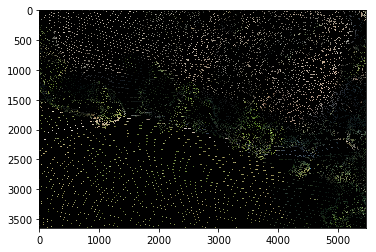

In [86]:
# plot image 
import matplotlib.pyplot as plt
plt.imshow(image)


In [89]:
filtered_colors.shape

(5681295, 3)

In [78]:
image_height*image_width

19961856

In [90]:
5681295/19961856

0.28460755352608497